# A few Things about Linear Concept Approximation

This Notebook is a part of the Thesis Project: Learning Multilingual Document Representations.
(Marc Lenz, 2021)


** **

## Linear Concept Approximation in General

**What is Linear Concept Approximation?**
- Method for Cross-Lingual information Retrieval. For two documents in different languages, lets say:
$d_{x=english},d_{y= french}$ we create vector representations $\bar{d_{x}} \in \mathbb{R}^{n} , \bar{d_{y} \in \mathbb{R}^{n_{x}}}$. Then we train a mapping from the english vector represenations to the french, $\theta: \mathbb{R}^{n}\rightarrow \mathbb{R}^{n}$. Where $ cos(\theta(\bar{d_{x=english}}), \bar{d_{y_french}})$ will give a good similarity measure.

**How is it computed?**

Given two sets of aligned documents $D_{x},D_{y}$ of two different Languages $L_{x}, L_{y}$,
we first create the Bag of Words (BOW) of each document for their respective language. 
This yields two sets of high-dimensional vectors. We convert these into matrices: $X\in \mathbb{R}^{n_{x}},Y\in \mathbb{R}^{n_{y}}$. Where the ith column of X,Y is the ith BOW vector of $d_{x,i}$
Followed by that we compute the r-truncted singular value decomposition of X and Y:
$X_{*k} = U \Sigma V_{*k}$ , same for Y.

Then, in the second step we want to find a mapping $\theta: X_{*k} \rightarrow Y_{*k}$, $\theta$ linear.
We use the least square loss $||X\theta-Y||_{2}^{2}$

##  1. Load Preprocessed Dataset

The original JRC-Arquis dataset have been preprocessed before. 
The aligned documents have been saved in two seperate csv files. 
For details of the preprocessing, check: read_and_preprocess.py

In [1]:
from Utils import read_docs
from sklearn.model_selection import train_test_split

# parse an xml file by name
french_docs, english_docs = read_docs('Data/jrq_aligned_10000_fr.csv', 'Data/jrq_aligned_10000_en.csv')
fr_docs_train, fr_docs_test, en_docs_train, en_docs_test = train_test_split(french_docs, english_docs, 
                                                                            test_size=0.1, random_state = 42)

print("Number of training Documents: "+ str(len(fr_docs_train)))
print("Number of test Documents: "+ str(len(fr_docs_test)))

Number of training Documents: 8759
Number of test Documents: 974


## 2.Training of Linear Concept Approximation
- Train LSI for different sample sizes and dimensions


In [2]:
from Utils import dict_combinations
from Utils import Vector_Lsi_Model, LCA_Model
import random 

sample_sizes = [1000, 2000, 3000, 4000, 5000, 6000]
dimensions = [100, 200, 300, 400, 500, 600, 700, 800]

#Creates List of Parameter Dictonaries
lsi_model_params = dict_combinations({"sample_size": sample_sizes, 
                                      "dimension" : dimensions})

#Train LSI Models with the given parameter list
lca_models = []
for param in lsi_model_params:
    
    #Get random sample
    sample_size = param["sample_size"]
    training_docs = list(zip(en_docs_train, fr_docs_train))
    random.shuffle(training_docs)
    en_docs_train_shuffled, fr_docs_train_shuffled = zip(*training_docs)
    sample_en = en_docs_train_shuffled[:sample_size]
    sample_fr = fr_docs_train_shuffled[:sample_size]
    
    #Now train models
    lsi_model_en = Vector_Lsi_Model(sample_en, dimension = param["dimension"])
    lsi_model_fr = Vector_Lsi_Model(sample_fr, dimension = param["dimension"])
    lca = LCA_Model(sample_en, sample_fr, lsi_model_en, lsi_model_fr)
    lca_models.append(lca)

## Evaluation
- Train LSI for different sample sizes and dimensions

In [3]:
from Utils import mate_retrieval_score

scores = []
for lca_model in lca_models:
    env = lca_model.create_embeddings(en_docs_test, language= "l1")
    frv = lca_model.create_embeddings(fr_docs_test, language= "l2")
    score = mate_retrieval_score(env, frv)
    scores.append(score)

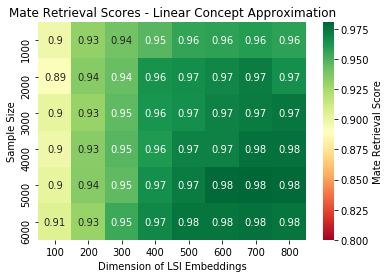

In [29]:
import numpy as np
import seaborn as sns


score_matrix = np.asarray(scores).reshape(len(sample_sizes),len(dimensions))
ax = sns.heatmap(score_matrix, vmin=0.8,
                 xticklabels=dimensions, 
                 yticklabels=sample_sizes,
                 cmap="RdYlGn", 
                 cbar_kws={'label': 'Mate Retrieval Score', 'orientation': 'vertical'},
                 annot=True
                )

plt.title("Mate Retrieval Scores - Linear Concept Approximation") 
plt.ylabel("Sample Size") 
plt.xlabel("Dimension of LSI Embeddings") 
plt.show()


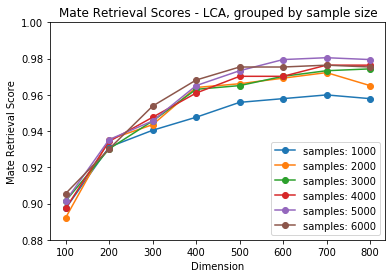

In [32]:
import matplotlib.pyplot as plt

for k in range(len(sample_sizes)):
    plt.plot(dimensions,score_matrix[k],"-o", label="samples: "+str(sample_sizes[k]))

plt.title("Mate Retrieval Scores - LCA, grouped by sample size")
plt.xlabel("Dimension")
plt.ylabel("Mate Retrieval Score")
plt.ylim((0.88,1))
plt.legend()
plt.show()

## Linear Concept Approximation from the viewpoint of Statistical Learning Theory

- Essential Question: If we know $X,Y$, can we make a good decision on how to choose the dimensionality k?

Even without knowing the distribution of variables, statistical learning theory allows some statements about the expected behaviour of learning algorithms. Sometimes it can be utilized to choose parameters. 

**Truncated Singular Value Decomposition and the Eckardt Young Theorem:**, the following holds:
for $n\geq r$ and $X\in \mathbb{R}^{n \times n}$

$argmin_{\bar{X}: rank(\bar{X})=d}||X-\bar{X_{|d}}||_{2}= U \Sigma V_{*d}$

- In general: larger d $\implies$ better matrix approximation

For the loss we have $||X-\bar{X_{|d}}||_{2}= \sum_{k=1}^{n} \sigma_{k} - \sum_{k=1}^{d} \sigma_{k} = \sum_{k=d+1}^{n} \sigma_{k} $

Furthermore: $Var(X_{|d}) = Var(U \Sigma V_{*d}) = Var(\Sigma_{|d})=\sum_{k=1}^{d} \sigma_{k}$

**Linear Regression:**
- $\hat{\theta} = \frac{1}{n}[X \theta - Y]_{2}^{2}$
- Following a proof from https://web.stanford.edu/class/cs229t/notes.pdf, the following holds:
$\mathbb{E}[L(\hat{\theta})-L(\theta^{*})]= \frac{d\sigma^{2}}{n}$

So in this context, that means: $\mathbb{E}[L(\hat{\theta})-L(\theta^{*})]= \frac{d}{n}\sum_{k=1}^{d} \sigma_{k}$

**The Resulting conflict: How to choose d?**

So we have to balance: 
- the d-rank approximation loss $||X-\bar{X_{|d}}||_{2}=  \sum_{k=d+1}^{n} \sigma_{k} $
- the the expected excess loss $\mathbb{E}[L(\hat{\theta})-L(\theta^{*})]= \frac{d}{n}\sum_{k=1}^{d} \sigma_{k}$


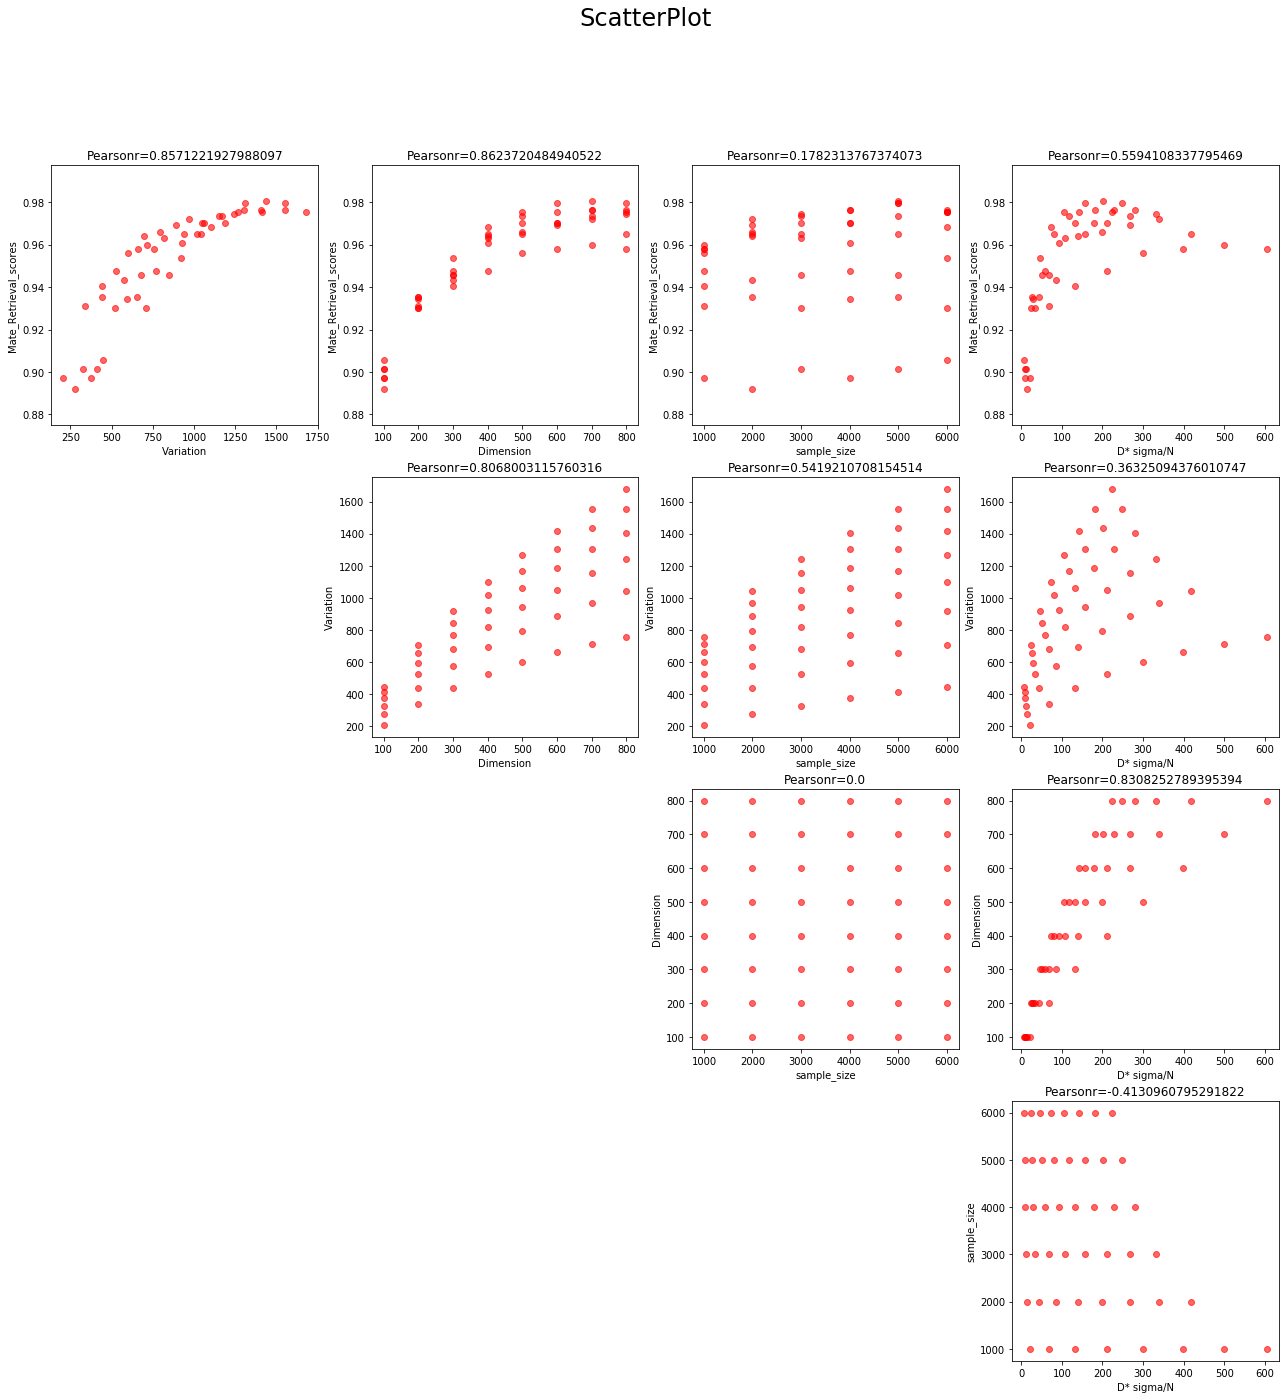

In [96]:
y_min = np.min(scores) - 0.01

excess_losses = []
s_dimensions = []
s_sample_sizes = []
s_variation = []

for k in range(len(lca_models)):
    lca_model = lca_models[k]
    #Find d,sigma,n
    singular_vals = lca_model.l1_lsi_model.lsi_model.projection.s
    sum_singular_vals = np.sum(singular_vals)
    dimension = lca_model.l1_lsi_model.dimension
    sample_size = lsi_model_params[k]["sample_size"]
    #
    s_dimensions.append(dimension) 
    s_sample_sizes.append(sample_size)
    s_variation.append(sum_singular_vals)
    excess_losses.append(dimension*sum_singular_vals/sample_size)
  

vars = [scores, s_variation, s_dimensions , s_sample_sizes, excess_losses]
var_labels = ["Mate_Retrieval_scores",
              "Variation",
              "Dimension",
              "sample_size",
              "D* sigma/N",
              ]


from scipy.stats import pearsonr
n = len(vars)
fig = plt.figure(figsize=(22,22))
fig.suptitle('ScatterPlot', fontsize=24)

for idy in range(n):
    for idx in range(n):
        ind = (n-1)*(idx) + idy 
        if idx < idy: #We only want one triangle
            ax1 = fig.add_subplot(n-1,n-1, ind)
        
            var_x = vars[idx]
            var_y = vars[idy]
            x_label = var_labels[idx]
            y_label = var_labels[idy]
            corellation , _ = pearsonr(var_x, var_y)
            
            ax1.scatter(var_y, var_x, c="red", alpha=0.6)
            ax1.set_xlabel(y_label)
            ax1.set_ylabel(x_label)
            ax1.set_title("Pearsonr="+str(corellation))
            
            
            
#ax1.title("Variance/Sum of Singular Values")






- The question is: Given the Variance and Sample size, can we choose the dimension optimally?